TODO: Add Title, TOC, Intro, Goal

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
f"pandas version: {pd.__version__}"

'pandas version: 2.1.4'

In [15]:
# Load the data
df = pd.read_csv("../data/interim/healthcare-stroke-data-preprocessed.csv", index_col='id')

In [16]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender,ever_married,residence_type,smoking_status_never_smoked,smoking_status_smokes,work_type_govt_job,work_type_never_worked,work_type_private,work_type_self_employed
id,,,,,,,,,,,,,,,
9046,67.0,0,1,228.69,36.6,1,0,1,1,0,1,0,0,1,0
51676,61.0,0,0,202.21,30.5,1,1,1,0,1,0,0,0,0,1
31112,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,0,1,0
60182,49.0,0,0,171.23,34.4,1,1,1,1,0,1,0,0,1,0
1665,79.0,1,0,174.12,24.0,1,1,1,0,1,0,0,0,0,1


In [17]:
df.shape

(5109, 15)

In [18]:
# independent variables
X = df.drop(columns='stroke')

# target / dependent variable
y = df['stroke']

X.shape, y.shape

((5109, 14), (5109,))

We can proceed to the model building phase of our analysis. First, we need to ensure that certain assumption hold about the data: these include our samples being independent and identically distributed, and that the independent variables are not collinear or show multicollinearity.

### Detecting Collinearity

This applies to Linear and Logistic Regression models.

c:\Users\anami\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


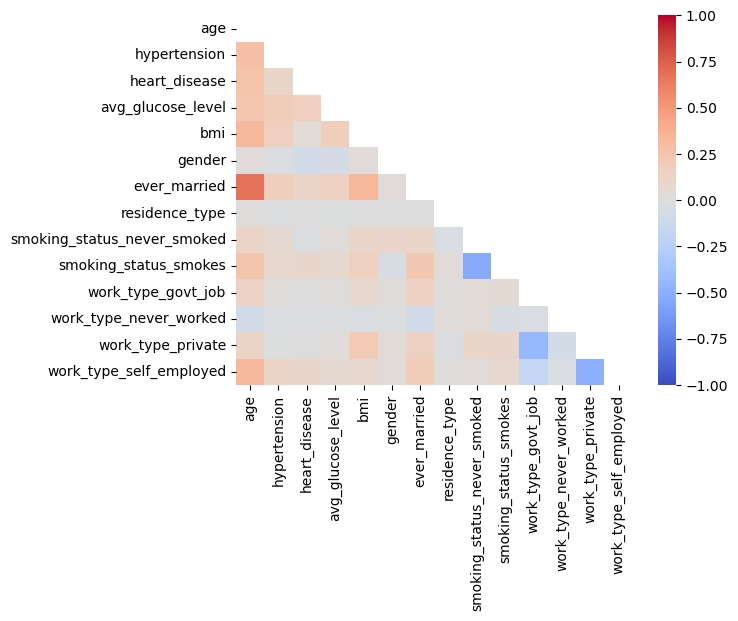

In [19]:
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure()
sns.heatmap(corr, mask=mask, center=0, annot=True, cmap="coolwarm", vmax=1.0, vmin=-1.0)
plt.show()

Ideally, we should not include multiple columns if they are correlated with one another strongly (>0.5 or  <-0.5):
- age and ever married

We will keep these in mind and not include the strongly correlated pairs in the model together, if we are using Logistic Regression

Also note that this correlation function is really best fit to evaluate the numeric columns, not the dummies.

## Split the data into train and test sets, and scale it

In [53]:
from sklearn.linear_model import LogisticRegression
# try with basic train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=19,
                                                    stratify=y)
# TODO: try with GridSearchCV


In [54]:
print(X_train_unscaled.shape)
print(X_test_unscaled.shape)

(3576, 14)
(1533, 14)


In [55]:
# After spliting our data, we can scale the data using Standard Scaler:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

Now we can proceed to do the modeling.

## Logistic regression

In [56]:
logreg = LogisticRegression()  # no hyperparameter optimization - TODO
logreg.fit(X_train, y_train)
score_train = logreg.score(X_train, y_train)
print(score_train)

0.9516219239373602


In [57]:
score_test = logreg.score(X_test, y_test)
print(score_test)

0.9510763209393346


Without hyperparameter optimization:  
Train scores: 95.16% accuracy  
Test scores: 95.1% accuracy  

Test set has an accuracy of 95.10 %, that's very close to the accuracy on the training set.

In [58]:
X_train_unscaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3576 entries, 45252 to 27436
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          3576 non-null   float64
 1   hypertension                 3576 non-null   int64  
 2   heart_disease                3576 non-null   int64  
 3   avg_glucose_level            3576 non-null   float64
 4   bmi                          3576 non-null   float64
 5   gender                       3576 non-null   int64  
 6   ever_married                 3576 non-null   int64  
 7   residence_type               3576 non-null   int64  
 8   smoking_status_never_smoked  3576 non-null   int64  
 9   smoking_status_smokes        3576 non-null   int64  
 10  work_type_govt_job           3576 non-null   int64  
 11  work_type_never_worked       3576 non-null   int64  
 12  work_type_private            3576 non-null   int64  
 13  work_type_self_emp

In our EDA we saw that age and ever_married are collinear. Let's drop ever_married and see whether it improves accuracy.

In [59]:
# X_train_mod = X_train.drop(columns=['ever_married'])
# X_test_mod = X_test.drop(columns=['ever_married'])
# X_train_mod = X_train.drop(columns=['age'])
# X_test_mod = X_test.drop(columns=['age'])
scaler2 = StandardScaler()
X_train_mod = scaler2.fit_transform(X_train_unscaled.drop(columns=['ever_married', 'gender', 'hypertension']))
X_test_mod = scaler2.transform(X_test_unscaled.drop(columns=['ever_married', 'gender', 'hypertension']))
logreg2 = LogisticRegression()
logreg2.fit(X_train_mod, y_train)

print(logreg2.score(X_train_mod, y_train))

print(logreg2.score(X_test_mod, y_test))


0.9513422818791947
0.9510763209393346


Removing features in decreasing the accuracy on the training set from 95.16% to 95.13%. We will keep all the features.

### Hyperparameter Optimization

Let's employ a GridSearch to see if we can get better scores from LogisticRegression

In [60]:
# Let's employ a GridSearch to see if we can get better scores from LogisticRegression
# Define the parameters that the GridSearch will search through
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'solver': ['saga', 'liblinear'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
]
# use GridSearchCv to search through LogisticRegression, cross-validation=5
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
fittedgrid = grid.fit(X_train, y_train)

c:\Users\anami\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\anami\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\anami\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\anami\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\anami\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\anami\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Let's see what the best hyperparameters and score for Logistic Regression are:

In [61]:
# Best hyperparameters
best_params = fittedgrid.best_params_
#best score
best_score = fittedgrid.best_score_
#print
print(f'Best parameters are: {best_params}')
print(f'Best score is: {best_score}')

Best parameters are: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best score is: 0.9516220650857521


Now we know what are the hyperparameters that logistic regression needs, and we can build the logistic regression with these parameters:

In [62]:
# instantiate the logistic regression model with the best hyperparameters
best_log_reg = LogisticRegression(C = 1,
                                  penalty = 'l1',
                                  solver = 'saga',
                                  )

#Fit training data
best_log_reg.fit(X_train, y_train)

#Print the train and test score
print(f'Train Score: {best_log_reg.score(X_train, y_train)}')
print(f'Test Score: {best_log_reg.score(X_test, y_test)}')

Train Score: 0.9516219239373602
Test Score: 0.9510763209393346


c:\Users\anami\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hyperparameter optimization didn't help improve the score significantly in this case.
| Hyperparameters Optimized? | Train Score | Test Score |
|----------------------------|------------:|-----------:|
| No                         |      95.16% |     95.10% |
| Yes                        |      95.18% |     95.10% |

## Support Vector Classifier

In [63]:
from sklearn.svm import SVC
svc = SVC() # there is a note about which metric to use in Huma article check that
svc.fit(X_train, y_train)
print(svc.score(X_train, y_train))
print(svc.score(X_test, y_test))

0.9513422818791947
0.9510763209393346


In [64]:
svc_gaussian = SVC(kernel='rbf')  # rbf is the default kernel?
svc_gaussian.fit(X_train, y_train)
print(svc_gaussian.score(X_train, y_train))
print(svc_gaussian.score(X_test, y_test))

0.9513422818791947
0.9510763209393346


### Hyperparameter Optimization

In [65]:
#define the parameters that the GridSearch will search through
param_grid = [
    {
        'C': [1e-2, 1, 1e2],
        'gamma': [1e-1, 1, 1e1],
        'kernel': ['rbf']
    }
]
#use GridSearch
grid = GridSearchCV(SVC(), param_grid, cv=5)
fittedgrid = grid.fit(X_train, y_train)

In [66]:
# Best hyperparameters
best_params = fittedgrid.best_params_
#best score
best_score = fittedgrid.best_score_
#print
print(f'Best parameters are: {best_params}')
print(f'Best score is: {best_score}')

Best parameters are: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
Best score is: 0.9513423448060319


We can see that the best parameters are:  

- C - 0.01
- gamma - 0.1
- kernel - 'rbf'

The best score of the GridSearch is 95.13%, which is less than the score for Logistic Regression. We still want to see how this does on the test set.

Now let's build the SVC model with those parameters:

In [67]:
# instantiate the SVC with the best hyperparameters
best_svc = SVC(kernel = 'rbf',
               C = 0.01,
               gamma = 0.1
               )
best_svc.fit(X_train, y_train)
#Print the train and test score
print(f'Train Score: {best_svc.score(X_train, y_train)}')
print(f'Test Score: {best_svc.score(X_test, y_test)}')

Train Score: 0.9513422818791947
Test Score: 0.9510763209393346


## Random Forest Classifier

In [68]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

1.0
0.9517286366601435


### Hyperparameter Optimization

In [69]:
#define the parameters that the GridSearch will search through
param_grid = [
    {
        'n_estimators': [10, 50, 100, 150, 200, 300, 400, 500],
        'max_depth': [10,20,30,40,50]
    }
]
#use GridSearch
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
fittedgrid = grid.fit(X_train, y_train)

In [70]:
# Best hyperparameters
best_params = fittedgrid.best_params_
#best score
best_score = fittedgrid.best_score_
#print
print(f'Best parameters are: {best_params}')
print(f'Best score is: {best_score}')

Best parameters are: {'max_depth': 10, 'n_estimators': 300}
Best score is: 0.9510626245263116


We can see that the best parameters are:  

- maximum depth - 10
- number of estimators - 500

The best score of the GridSearch is 95.08%, which is less than the score for Logistic Regression and Support Vector Machine. We still want to see how this does on the test set.

Now let's build the Random Forest Classifier model with those parameters:

In [71]:
# instantiate the Random Forest Classifier with the best hyperparameters
best_ran_f = RandomForestClassifier(max_depth = 10,
                                       n_estimators= 500
                                    )
best_ran_f.fit(X_train, y_train)
#Print the train and test score
print(f'Train Score: {best_ran_f.score(X_train, y_train)}')
print(f'Test Score: {best_ran_f.score(X_test, y_test)}')

Train Score: 0.9714765100671141
Test Score: 0.9510763209393346


| Model               | Hyperparameters optimized? | Train Score (accuracy) | Test Score (accuracy) |
|---------------------|---------------------------:|-----------------------:|-----------------------|
| Logistic Regression | No                         | 95.16%                 | 95.11%                |
|                     | Yes                        | 95.18%                 | 95.11%                |
| SVC                 | No                         | 95.15%                 | 95.11%                |
|                     | Yes                        | 95.13%                 | 95.11%                |
| Random Forest       | No                         | 100%                   | 94.91%                |
|                     | Yes                        | 97.14%                 | 95.11%                |

It looks like the maximum accuracy we are seeing for the test set is 95.11%. Let's look at the precision, recall, and confusion matrix of these models to see if there is any distinguishable advantage of one over the others.

## Model Evaluation

### Classification report